# MountainCar

In [23]:
import gym
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from collections import deque
import numpy as np
import random
from tqdm import tqdm  # shows where we are through training
import matplotlib.pyplot as plt   # to show off results
from scipy.stats import sem   # to show off confidence intervals

MountainCar gives the position and velocity in the range $\left[ -1.2, 0.6 \right] \times\left[ -0.07, 0.07 \right]$.

In [24]:
env_name = "MountainCar-v0"
env = gym.make(env_name)

gamma = 0.99 # discount factor (want it high because we only care about the end)
learning_rate = 0.0005  # learning rate   # 0.0005 gets -101
batch_size = 32   # how many experiences to train on at once
memory_length = 20000   # 20000 gets -101

state_size = env.observation_space.shape[0]   # state dimension
action_size = env.action_space.n   # 0, 1, or 2

num_trials = 1200   # 1200 gets -101
test_freq = 25   # after how many trials do we want to look at results?
num_tests = 40    # how many tests in each test
rendered_tests = 5   # how many rendered tests at the end?
extra_tests = 400   # at the end, how many additional tests do we want to do that are not rendered?
prec = 3   # precision when printing results

epsilon = 1  # start by moving randomly
epsilon_min = .025  # minimum epsilon
epsilon_episodes = int(num_trials/2)  # after this many episodes, have epsilon_min

In [25]:
def create_DQN():

    input_layer = layers.Input(shape=env.observation_space.shape)
    
    x = layers.Dense(64, activation='relu')(input_layer)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    
    Q_output = layers.Dense(env.action_space.n, activation='linear')(x)
    
#     y = layers.Dense(24, activation='relu')(x)
    merge_layer = layers.concatenate([x, input_layer])
    state_hidden = layers.Dense(32, activation='relu')(merge_layer)
    state_pred_output = layers.Dense(env.observation_space.shape[0], activation='linear')(state_hidden)
    
    DQN = models.Model(inputs=input_layer, outputs=[Q_output, state_pred_output])
    
    adam = optimizers.Adam(lr=learning_rate)

    DQN.compile(loss=losses.mse, optimizer=adam, metrics=['accuracy']);
    
    return DQN

DQN = create_DQN()
DQN.summary()
target_DQN = create_DQN()  # fixed Q targets
target_DQN.set_weights(DQN.get_weights())   # fixed Q targets
# didn't exist

# target_DQN = DQN # this bad don't do

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 64)           192         input_5[0][0]                    
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 64)           4160        dense_24[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 32)           2080        dense_25[0][0]                   
____________________________________________________________________________________________

In [26]:
# https://github.com/pythonlessons/Reinforcement_Learning/blob/master/05_CartPole-reinforcement-learning_PER_D3QN/PER.py
class SumTree(object):
    data_pointer = 0
    
    # Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    def __init__(self, capacity):
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema below
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
    
    
    # Here we define function that will add our priority score in the sumtree leaf and add the experience in data:
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1

        # Update data frame
        self.data[self.data_pointer] = data

        # Update the leaf
        self.update (tree_index, priority)

        # Add 1 to data_pointer
        self.data_pointer += 1

        if self.data_pointer >= self.capacity:  # If we're above the capacity, we go back to first index (we overwrite)
            self.data_pointer = 0
            
    # Update the leaf priority score and propagate the change through tree
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        # this method is faster than the recursive loop in the reference code
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
        
    # Here build a function to get a leaf from our tree. So we'll build a function to get the leaf_index, priority value of that leaf and experience associated with that leaf index:
    def get_leaf(self, v):
        parent_index = 0

        # the while loop is faster than the method in the reference code
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else: # downward search, always search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node

# Now we finished constructing our SumTree object, next we'll build a memory object.
class Memory(object):  # stored as ( state, action, reward, next_state ) in SumTree
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.8  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.5  # importance-sampling, from initial value increasing to 1

    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 2  # clipped abs error

    def __init__(self, env, capacity, amount_filled=1):
        # Making the tree 
        self.tree = SumTree(capacity)
        step = 0
        while step < int(capacity*amount_filled):   # only fill to approximately half (by default)
            s = env.reset()
            done = False
            while not done:
                a = env.action_space.sample()
                s1, r, done, info = env.step(a)
                self.remember([s,a,r,s1,done])
                s = s1
                step += 1
        env.close()
        
    # Next, we define a function to store a new experience in our tree.
    # Each new experience will have a score of max_prority (it will be then improved when we use this exp to train our DDQN).
    def remember(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        # If the max priority = 0 we can't put priority = 0 since this experience will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)   # set the max priority for new priority
        
    # Now we create sample function, which will be used to pick batch from our tree memory, which will be used to train our model.
    # - First, we sample a minibatch of n size, the range [0, priority_total] into priority ranges.
    # - Then a value is uniformly sampled from each range.
    # - Then we search in the sumtree, for the experience where priority score correspond to sample values are retrieved from.
    def sample(self, n=batch_size):
        # Create a minibatch array that will contains the minibatch
        minibatch = []

        b_idx = np.empty((n,), dtype=np.int32)

        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment

        for i in range(n):
            # A value is uniformly sample from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            # Experience that correspond to each value is retrieved
            index, priority, data = self.tree.get_leaf(value)

            b_idx[i]= index

            minibatch.append([data[0],data[1],data[2],data[3],data[4]])

        return b_idx, minibatch
    
    # Update the priorities on the tree
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

memory = Memory(env, memory_length, 0.1)

In [27]:
# Train our neural network
def train(DQN):
    tree_idx, batch = memory.sample()
    s_mb = np.array([each[0].reshape(env.observation_space.shape[0],) for each in batch])
#     s_mb = s_mb.reshape(batch_size, env.observation_space.shape[0]) #######################################################
    a_mb = np.array([each[1] for each in batch])
    r_mb = np.array([each[2] for each in batch])
    s1_mb = np.array([each[3].reshape(env.observation_space.shape[0],) for each in batch])
#     s1_mb = s1_mb.reshape(batch_size, env.observation_space.shape[0]) #######################################################
    done_mb = np.array([each[4] for each in batch])
    
    # Get future Q values
    future_Qs = target_DQN.predict(s1_mb)[0]  # fixed Q targets
# was   future_Qs = DQN.predict(s1_mb)
    output = DQN.predict(s_mb)
    targets_mb = output[0].copy()
    state_pred = output[1].copy()
    targets_old = output[0].copy()   # PER
    del output
    for i in range(len(batch)):     # r if done, r+gamma*Q(s') else
        terminal = done_mb[i]
        a = a_mb[i]

        if terminal:
          target = r_mb[i]
        else:
          target = r_mb[i] + gamma*future_Qs[i][np.argmax(targets_mb[i])]   # Double DQN
#    was  target = r_mb[i] + gamma*np.max(future_Qs[i])   # Double DQN

        targets_mb[i][a] = target
    targets_mb = np.array(targets_mb)
    target_diff_prios = np.sum(np.abs(targets_old-targets_mb), axis=1)  # PER
    pred_prios = np.sum(np.abs(state_pred-s1_mb), axis=1)
    memory.batch_update(tree_idx, target_diff_prios + pred_prios)  # PER
    
    hist = DQN.fit(s_mb, [targets_mb, s1_mb], epochs=1, verbose=False, batch_size = batch_size)
    loss = hist.history['loss'][0]

    return loss


# A function to select an action based on the current Q table and epsilon

def select_action(state, eps):
    if np.random.rand() < eps:   # chance we pick a random action
        return np.random.randint(action_size)
    Qs = DQN.predict(state.reshape(1,state_size))
    return np.argmax(Qs[0])



# Test current Q_table

def tester(env):
    test_list = []
    for _ in range(num_tests):
        done = False
        total = 0
        s = env.reset()
        while not done:
            a = select_action(s, 0)   # epsilon = 0 means always choose best action
            s, r, done, _ = env.step(a)
            total += r
        test_list.append(total)
    return test_list   # return average total score
    


# Efficiently computes moving averages

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


# Produce important statistics for confidence intervals

def confidence_interval_maker95(my_list):
    std_error = sem(my_list)
    sample_mean = np.mean(my_list)
    return round(sample_mean-1.96*std_error, prec), sample_mean, round(sample_mean+1.96*std_error, prec)

In [28]:
# Housekeeping stuff
env = gym.make(env_name)   # create environment
epsilon_decay = (epsilon-epsilon_min)/epsilon_episodes # how quickly epsilon decays


# For Visualization of Results
rewards_list = []
max_pos_list = []
loss_list = []
test_rewards = []

In [7]:
# Train
for episode in tqdm(range(num_trials)):
    score = 0
    s = env.reset()
    done = False
    step = 0
    max_pos = -2
    while not done:
        a = select_action(s, epsilon)
        s1, r, done, _ = env.step(a)
        max_pos = min(max(s1[0], max_pos),0.5)
        memory.remember([s,a,r,s1,done])

        score += r
        if step % 1 == 0:
            loss = train(DQN)
            loss_list.append(loss)

        if done:
            epsilon -= epsilon_decay
            max_pos_list.append(max_pos)
            break

        s = s1
        step += 1

    rewards_list.append(score)

    target_DQN.set_weights(DQN.get_weights()) # fixed Q targets
# didn't exist
    
    if episode % test_freq == 0:
        test_rewards.append(tester(env))

env.close()

100%|██████████████████████████████████████████████████████████████████| 1200/1200 [1:12:33<00:00,  3.63s/it]


In [8]:
moving_average_len = int(np.floor(len(rewards_list)/15))
moving_average = running_mean(rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Training Rewards')
ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

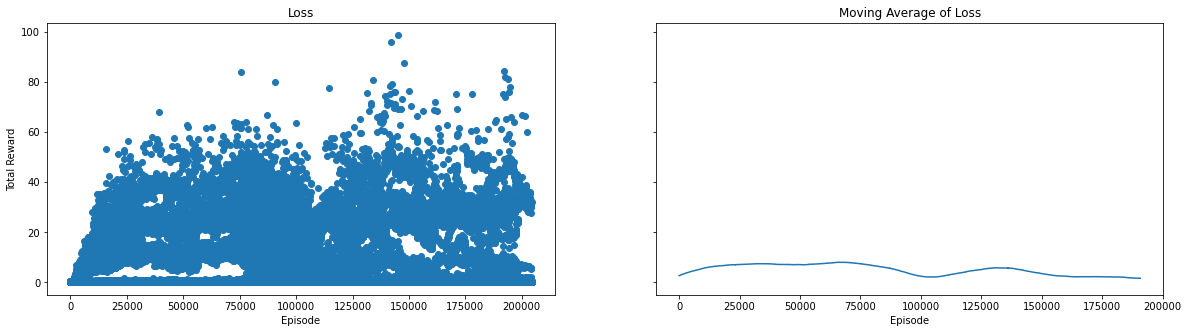

In [9]:
moving_average_len = int(np.floor(len(loss_list)/15))
moving_average = running_mean(loss_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Loss')
ax1.scatter([i+1 for i in range(len(loss_list))], loss_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Loss')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

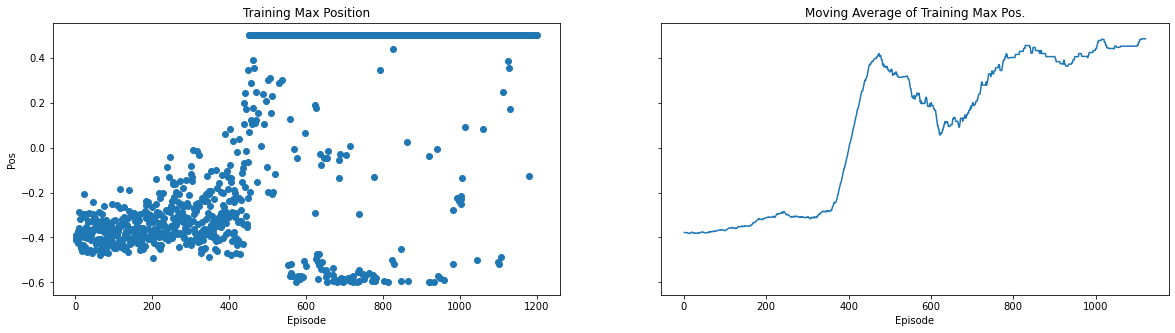

In [10]:
moving_average_len = int(np.floor(len(max_pos_list)/15))
moving_average = running_mean(max_pos_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Training Max Position')
ax1.scatter([i+1 for i in range(len(max_pos_list))], max_pos_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Pos')


ax2.set_title('Moving Average of Training Max Pos.')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

Populating the interactive namespace from numpy and matplotlib


C:\Users\carno\anaconda3\envs\rl_fixer\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'gamma', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


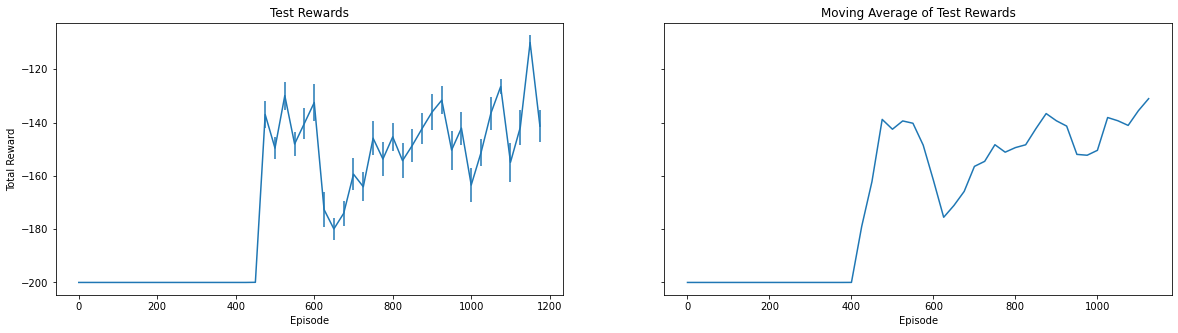

In [11]:
%pylab inline

test_means = np.mean(test_rewards, axis=1)
test_sem = sem(test_rewards, axis=1)

moving_average_len = int(np.floor(len(test_means)/15))
moving_average = running_mean(test_means, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Test Rewards')
ax1.errorbar([i*test_freq for i in range(len(test_rewards))], test_means, test_sem)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Test Rewards')
ax2.plot([i*test_freq for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

In [12]:
import pandas as pd
X = np.random.uniform(-1.2, 0.6, 20000)
Y = np.random.uniform(-0.07, 0.07, 20000)
Z = []
for i in range(len(X)):
    state = np.array([X[i], Y[i]])
    Z.append(select_action(state, 0))   # select action
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,len(colors.unique())):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

In [13]:
final_test_list = []
for _ in range(extra_tests):
    done = False
    total = 0
    s = env.reset()
    while not done:
        a = select_action(s, 0)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        total += r
    final_test_list.append(total)
for _ in range(rendered_tests):
    done = False
    total = 0
    s = env.reset()
    env.render()
    while not done:
        a = select_action(s, 0)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        env.render()
        total += r
    final_test_list.append(total)
env.close()
low, sample_mean, high = confidence_interval_maker95(final_test_list)
print("Average Reward: {}".format(round(sample_mean, prec)))   # return average total score
print("The best trial had a reward of {}.".format(np.max(test_rewards)))
print("We have 95% confidence that the true average reward is between {} and {}.".format(low, high))

Average Reward: -118.126
The best trial had a reward of -83.0.
We have 95% confidence that the true average reward is between -120.118 and -116.134.


# Modifed MountainCar

In [29]:
# Housekeeping stuff
env = gym.make(env_name)   # create environment
epsilon = 1
epsilon_decay = (epsilon-epsilon_min)/epsilon_episodes # how quickly epsilon decays
gamma = 0.99

memory = Memory(env, memory_length) # Remake memory
DQN = create_DQN()   # remake DQN
target_DQN = create_DQN()
target_DQN.set_weights(DQN.get_weights())


# For Visualization of Results
rewards_list = []
max_pos_list = []
test_rewards = []
loss_list = []
true_rewards_list = []

In [30]:
# Train
for episode in tqdm(range(num_trials)):
    score = 0
    true_score = 0
    s = env.reset()
    done = False
    max_pos = -2
    step = 0
    while not done:
        a = select_action(s, epsilon)
        s1, r, done, _ = env.step(a)
        max_pos = min(max(s1[0], max_pos),0.5)
        
        true_score += r
        r += min(s1[0], 0.5)/100
        
        memory.remember([s,a,r,s1,done])

        score += r
        if step % 1 == 0:
            loss = train(DQN)
            loss_list.append(loss)

        if done:
            epsilon -= epsilon_decay
            max_pos_list.append(max_pos)
            break

        s = s1

    rewards_list.append(score)
    true_rewards_list.append(true_score)
    target_DQN.set_weights(DQN.get_weights()) #######################################################
    
    step += 1
    
    if episode % test_freq == 0:
        test_rewards.append(tester(env))

env.close()

100%|█████████████████████████████████████████████| 1200/1200 [1:27:01<00:00,  4.35s/it]


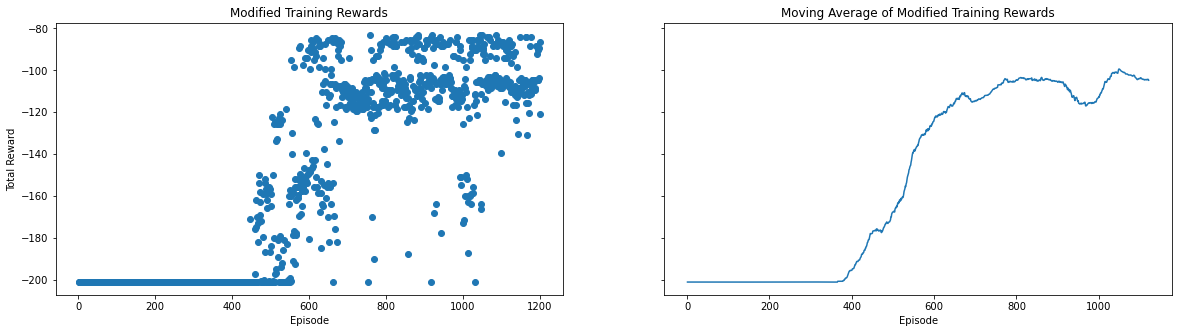

In [31]:
moving_average_len = int(np.floor(len(rewards_list)/15))
moving_average = running_mean(rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Modified Training Rewards')
ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Modified Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

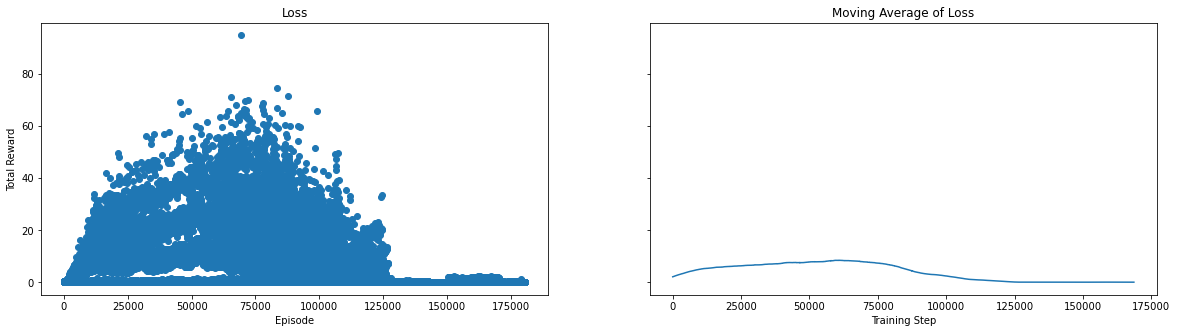

In [32]:
moving_average_len = int(np.floor(len(loss_list)/15))
moving_average = running_mean(loss_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Loss')
ax1.scatter([i+1 for i in range(len(loss_list))], loss_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Loss')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Training Step');

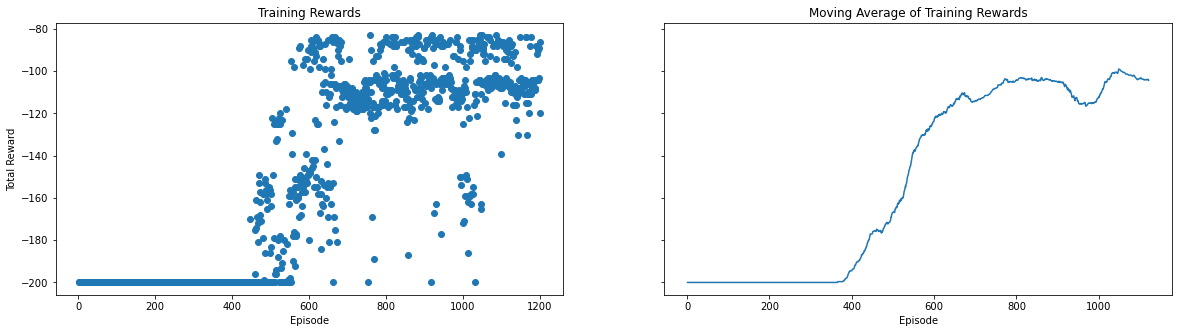

In [33]:
moving_average_len = int(np.floor(len(true_rewards_list)/15))
moving_average = running_mean(true_rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Training Rewards')
ax1.scatter([i+1 for i in range(len(true_rewards_list))], true_rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

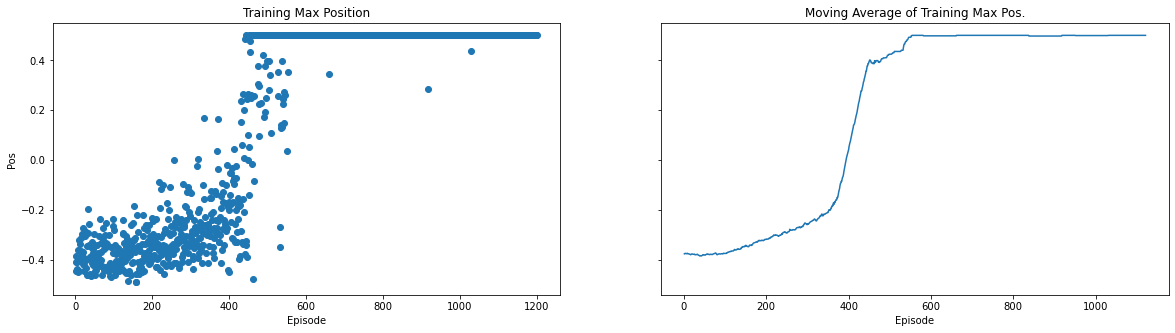

In [34]:
moving_average_len = int(np.floor(len(max_pos_list)/15))
moving_average = running_mean(max_pos_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Training Max Position')
ax1.scatter([i+1 for i in range(len(max_pos_list))], max_pos_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Pos')


ax2.set_title('Moving Average of Training Max Pos.')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

In [35]:
%pylab inline

test_means = np.mean(test_rewards, axis=1)
test_sem = sem(test_rewards, axis=1)

moving_average_len = int(np.floor(len(test_means)/15))
moving_average = running_mean(test_means, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,5))

ax1.set_title('Test Rewards')
ax1.errorbar([i*test_freq for i in range(len(test_rewards))], test_means, test_sem)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Test Rewards')
ax2.plot([i*test_freq for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

Populating the interactive namespace from numpy and matplotlib


C:\Users\carno\anaconda3\envs\rl_fixer\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'gamma', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [36]:
import pandas as pd
X = np.random.uniform(-1.2, 0.6, 20000)
Y = np.random.uniform(-0.07, 0.07, 20000)
Z = []
for i in range(len(X)):
    state = np.array([X[i], Y[i]])
    Z.append(select_action(state, 0))   # select action
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,len(colors.unique())):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

In [37]:
final_test_list = []
for _ in range(extra_tests):
    done = False
    total = 0
    s = env.reset()
    while not done:
        a = select_action(s, 0)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        total += r
    final_test_list.append(total)
for _ in range(rendered_tests):
    done = False
    total = 0
    s = env.reset()
    env.render()
    while not done:
        a = select_action(s, 0)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        env.render()
        total += r
    final_test_list.append(total)
env.close()
low, sample_mean, high = confidence_interval_maker95(final_test_list)
print("Average Reward: {}".format(round(sample_mean, prec)))   # return average total score
print("The best trial had a reward of {}.".format(np.max(test_rewards)))
print("We have 95% confidence that the true average reward is between {} and {}.".format(low, high))

Average Reward: -120.983
The best trial had a reward of -83.0.
We have 95% confidence that the true average reward is between -123.332 and -118.634.
